In [67]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.tbats import TBATS
import numpy as np
import math
from dateutil.relativedelta import relativedelta
from pmdarima.arima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from darts.models import NBEATSModel
from statsmodels.tsa.api import ExponentialSmoothing
from sktime.forecasting.tbats import TBATS
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima
import arch

In [84]:
class randomForestmodel:
    def __init__(self,train):
        train = train.copy()
        cols = train.columns
        self.last = train.values.ravel()[-1]
        self.start_date = train.index[-1] + relativedelta(months = 1)
        train['mes'] = train.index.month
        train['quarter'] = train.index.quarter
        train['ano'] = train.index.year
        x_values = train[['mes','quarter','ano']].values
        y_train = train.drop(['mes','quarter','ano'],axis = 1).values.ravel()
        self.model = RandomForestRegressor(max_depth=100, random_state=0).fit(x_values,y_train)
    def predict(self,n):
        datas = pd.date_range(start = self.start_date,periods = n,freq = 'm')
        x_df = pd.DataFrame(index = datas)
        x_df['mes'] = x_df.index.month
        x_df['quarter'] = x_df.index.quarter
        x_df['ano'] = x_df.index.year
        x_values = x_df.values
        return self.model.predict(x_values)

In [3]:
class ARIMAmodel:
    def __init__(self,train):
        self.model = auto_arima(train, start_p=1, start_q=1,
                        test='adf',
                        max_p=5, max_q=5,
                        m=1,             
                        d=1,          
                        seasonal=True,   
                        start_P=0, 
                        D=None, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    def predict(self,n):
        return self.model.predict(n_periods=n)

In [71]:
class NBEATS:
    def __init__(self,main_series):#,extra_series):
        self.data = TimeSeries.from_dataframe(main_series)
        # self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        # self.scaler_x = Scaler()
        # self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = NBEATSModel(
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            # past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data)#, past_covariates = self.transformed_extra_data)
        converted_predictions = self.scaler_y.inverse_transform(prediction).values().ravel()
        return converted_predictions

In [2]:
mapa = {'janeiro':1,'fevereiro':2,'março':3,'abril':4,'maio':5,'junho':6,'julho':7,'agosto':8,'setembro':9,'outubro':10,'novembro':11,'dezembro':12}
df = pd.read_excel('Média Mensal Comercial por Submercado.xlsx',header = 1,index_col = 'Submercado').T.reset_index()
df['index'] = df['index'].apply(lambda x: datetime(int(x.split()[2]),mapa[x.split()[0]],1))
df = df.set_index('index')
df.columns.name = None

<AxesSubplot:xlabel='index'>

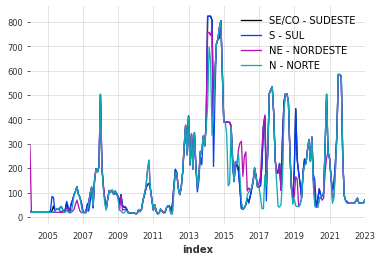

In [16]:
df.plot()

MSE: 43301.46928975498


<AxesSubplot:xlabel='index'>

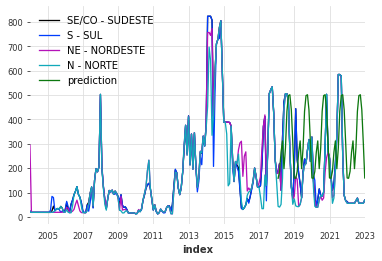

In [90]:
train,test = df.apply(lambda x: x.mean(),axis = 1).iloc[:-60].to_frame(),df.apply(lambda x: x.mean(),axis = 1).iloc[-60:].values.ravel()
model = randomForestmodel(train)
prediction = model.predict(60)
pred_df = df.copy()
pred_df['prediction'] = ([None] * (len(df) - len(prediction))) + list(prediction)
print('MSE:',mean_squared_error(test,prediction))
pred_df.plot()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1959.933, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1961.540, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1961.473, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1957.938, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.602 seconds
MSE: 23652.469556354168


<AxesSubplot:xlabel='index'>

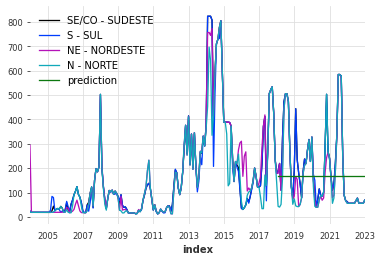

In [93]:
train,test = df.apply(lambda x: x.mean(),axis = 1).iloc[:-60].values,df.apply(lambda x: x.mean(),axis = 1).iloc[-60:].values.ravel()
model = ARIMAmodel(train)
prediction = model.predict(60)
pred_df = df.copy()
pred_df['prediction'] = ([None] * (len(df) - len(prediction))) + list(prediction)
print('MSE:',mean_squared_error(test,prediction))
pred_df.plot()

MSE: 24338.60917967019


<AxesSubplot:xlabel='index'>

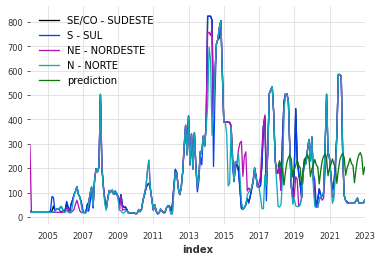

In [95]:
train,test = df.apply(lambda x: x.mean(),axis = 1).iloc[:-60].values,df.apply(lambda x: x.mean(),axis = 1).iloc[-60:].values.ravel()
model = ExponentialSmoothing(train,trend = 'add',seasonal = 'add',seasonal_periods = 12).fit(smoothing_level=0.8)
prediction = model.forecast(60)
pred_df = df.copy()
pred_df['prediction'] = ([None] * (len(df) - len(prediction))) + list(prediction)
print('MSE:',mean_squared_error(test,prediction))
pred_df.plot()

2023-02-10 14:28:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 98 samples.
2023-02-10 14:28:45 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2023-02-10 14:28:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2023-02-10 14:28:45 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2023-02-10 14:28:45 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2023-02-10 14:28:45 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


<AxesSubplot:xlabel='index'>

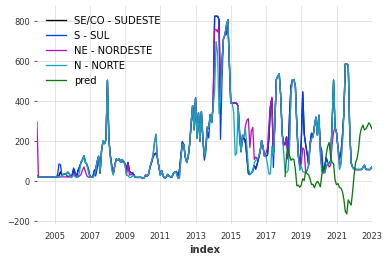

In [82]:
train = df.apply(lambda x: x.mean(),axis = 1).iloc[:-60].to_frame()
model = NBEATS(train).fit(12,60)
predictions = pd.Series(model.predict(60)).rolling(6,1).mean().values
pred_df = df.copy()
pred_df['pred'] = ([None] * (len(df) - len(predictions))) + list(predictions)
pred_df.plot()

<AxesSubplot:xlabel='index'>

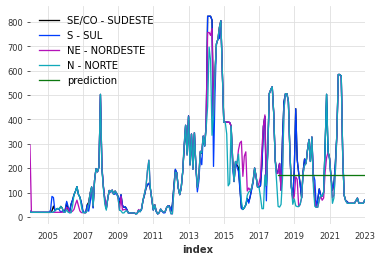

In [63]:
train = df.apply(lambda x: x.mean(),axis = 1).iloc[:-60].values
forecaster = TBATS(sp=12,n_jobs=100,box_cox_bounds = (0,10))
forecaster.fit(train) 
prediction = forecaster.predict(fh=list(range(1,61))).ravel()
pred_df = df.copy()
pred_df['prediction'] = ([None] * (len(df) - len(prediction))) + list(prediction)
pred_df.plot()

<AxesSubplot:xlabel='index'>

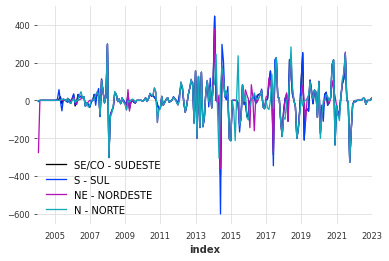

In [81]:
df.diff().plot()

MSE: 40103.1929772771


<AxesSubplot:xlabel='index'>

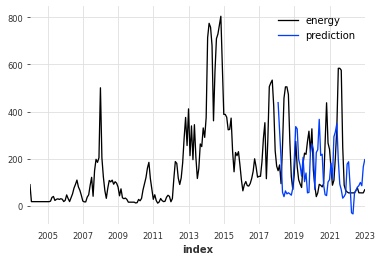

In [60]:
new = df.apply(lambda x: x.mean(),axis = 1).to_frame().rename({0:'energy'},axis = 1).iloc[:-60].copy()
test = df.apply(lambda x: x.mean(),axis = 1).iloc[-60:].values
new['ma'] = [new['energy'].mean()] * len(new)
vales = new.apply(lambda x: x['energy'] if x['ma'] > x['energy'] else None,axis = 1)
picos = new.apply(lambda x: x['energy'] if x['ma'] < x['energy'] else None,axis = 1)
vales_mean = vales.dropna().mean()
vales_std = vales.dropna().std()
picos_mean = picos.dropna().mean()
picos_std = picos.dropna().std()
pico_chance = len(picos.dropna()) / len(picos)
def simulate():
    if random.random() < pico_chance:
        return np.random.normal(picos_mean,picos_std)
    return np.random.normal(vales_mean,vales_std)
prediction = pd.Series([simulate() for _ in range(60)]).rolling(3,1,center = True).mean().values
pred_df = df.apply(lambda x: x.mean(),axis = 1).to_frame().rename({0:'energy'},axis = 1)
pred_df['prediction'] = ([None] * (len(pred_df) - len(prediction))) + list(prediction)
print('MSE:',mean_squared_error(test,prediction))
pred_df.plot()

MSE: 36511.41048477921


<AxesSubplot:xlabel='index'>

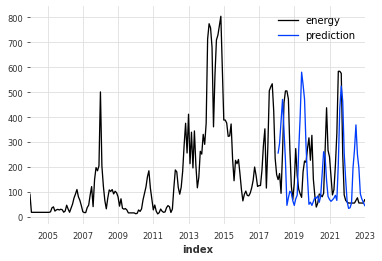

In [36]:
new = df.apply(lambda x: x.mean(),axis = 1).to_frame().rename({0:'energy'},axis = 1).iloc[:-60].copy()
test = df.apply(lambda x: x.mean(),axis = 1).iloc[-60:].values
new['ma'] = [new['energy'].mean()] * len(new)
vales = new.apply(lambda x: x['energy'] if x['ma'] > x['energy'] else None,axis = 1)
picos = new.apply(lambda x: x['energy'] if x['ma'] < x['energy'] else None,axis = 1)
vales_mean = vales.dropna().mean()
vales_std = vales.dropna().std()
picos_mean = picos.dropna().mean()
picos_std = picos.dropna().std()
def count_holes(serie):
    count = 0
    last = 0
    for valor in serie:
        if np.isnan(valor) and not np.isnan(last):
            count += 1
        last = valor
    return count
chance_vale = count_holes(vales) / (len(vales.dropna()) - 1)
chance_pico = 1 - (count_holes(picos) / (len(picos.dropna()) - 1))
trashold = new['energy'].mean()
minimo = new['energy'].min()
def simulate(last,n):
    for _ in range(n):
        rand = random.random()
        if last > trashold:
            if rand < chance_pico:
                valor = np.random.normal(picos_mean,picos_std)
            else:
                valor = np.random.normal(vales_mean,vales_std)
        else:
            if rand < chance_vale:
                valor = np.random.normal(picos_mean,picos_std)
            else:
                valor = np.random.normal(vales_mean,vales_std)
        last = valor
        yield valor if valor >= minimo else minimo
predictor = simulate(new['energy'].iloc[-1],60)
prediction = pd.Series([x for x in predictor]).rolling(3,1,center = True).mean().values
pred_df = df.apply(lambda x: x.mean(),axis = 1).to_frame().rename({0:'energy'},axis = 1)
pred_df['prediction'] = ([None] * (len(pred_df) - len(prediction))) + list(prediction)
print('MSE:',mean_squared_error(test,prediction))
pred_df.plot()

In [45]:
dif = new['energy'].diff().dropna()

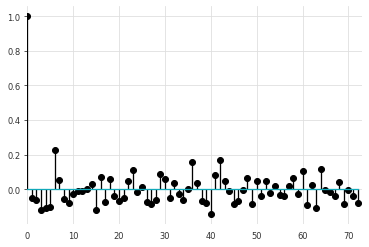

In [47]:
f = plt.figure()
plt.subplot(1,1,1)
autocorr = acf(dif,nlags = 72)
lg = range(0,73)
plt.stem(lg,autocorr)
plt.xlim([0,73])
plt.show()

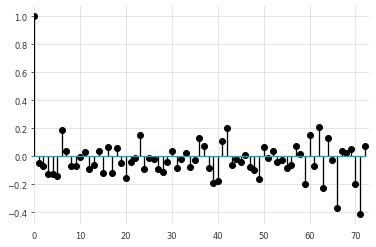

In [48]:
f = plt.figure()
plt.subplot(1,1,1)
autocorr = pacf(dif,nlags = 72)
lg = range(0,73)
plt.stem(lg,autocorr)
plt.xlim([0,73])
plt.show()

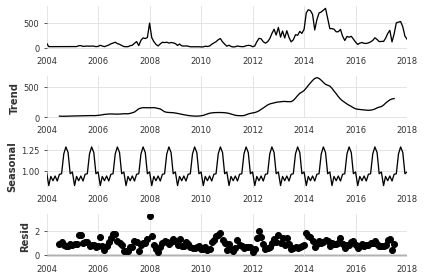

In [52]:
series = new[['energy']]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show()